Here we will perform image segmentation in a method according to this paper: https://www.notion.so/Master-s-Thesis-f4198941092e4564b0ab388bf92c8a56#085d8dd355a9481ea3ed3b8743797baa.

Import image and work out which channel we should use. Pick image with widest distributed historgram.

I wonder if you could do something clever with PCA to choose a linear combination of RGB which maximises variance. Another time perhaps

In [374]:
import cv2
import scipy.stats.qmc as qmc
import matplotlib.pyplot as plt 
import numpy as np
import pickle
import csv
import random
random_seed = 0
hyperparameter_dictionary = {}
reader = csv.DictReader(open('hyperparameters.csv'))
for row in reader:
    hyperparameter_dictionary = row
    break

In [375]:
def hyp(key):
    return np.float16(hyperparameter_dictionary[key])

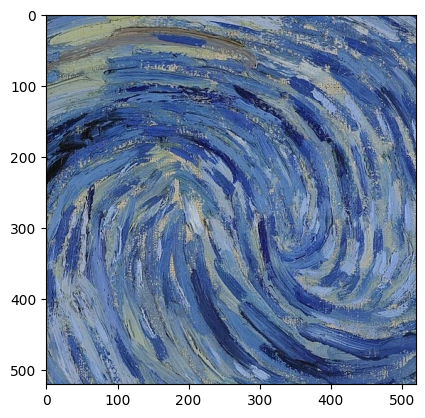

(520, 520, 3)


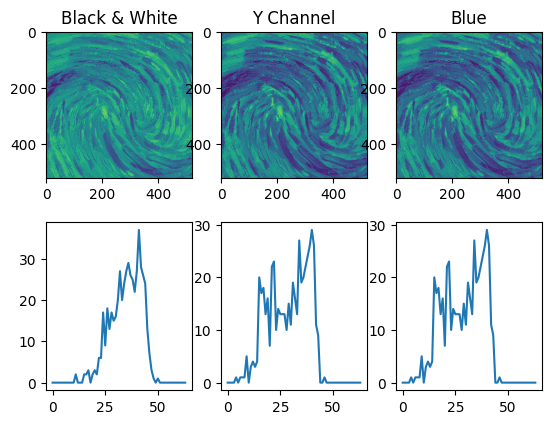

In [376]:

im = cv2.imread('../res/starry_night_crop.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()
im_Y = cv2.cvtColor(im, cv2.COLOR_BGR2YCR_CB)
im_Y = im[:,:,0]
im_bw = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_B = im[:,:,0]
print(im.shape)
plt.subplot(2,3,1)
plt.title("Black & White")
plt.imshow(im_bw)
plt.subplot(2,3,2)
plt.title("Y Channel")
plt.imshow(im_Y)
plt.subplot(2,3,3)
plt.title("Blue")
plt.imshow(im_B)
plt.subplot(2,3,4)
plt.plot(cv2.calcHist(im_bw, [0], None,[64],[0,256]))
plt.subplot(2,3,5)
plt.plot(cv2.calcHist(im_Y, [0], None,[64],[0,256]))
plt.subplot(2,3,6)
plt.plot(cv2.calcHist(im_B, [0], None,[64],[0,256]))




Let's actually try the PCA thing...

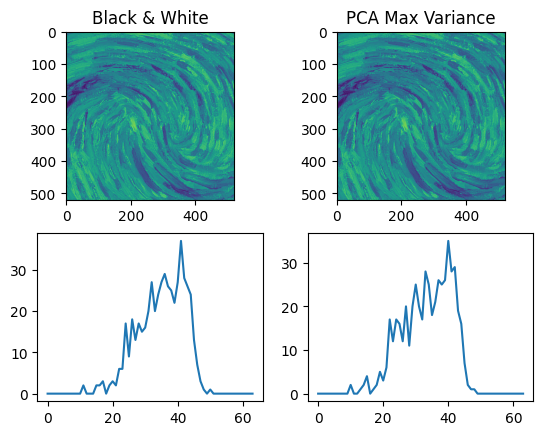

In [377]:
#First let's try to do a covariance matrix 😬
im_r = im[:,:,2]
im_g = im[:,:,1]
im_b = im[:,:,0]

#Reshape them into vectors, rather than matrices
im_r_flat = np.reshape(im_r, [1,np.size(im_r)])
im_g_flat = np.reshape(im_g, [1,np.size(im_r)])
im_b_flat = np.reshape(im_b, [1,np.size(im_r)])

#Subtract mean
im_r_flat = im_r_flat - np.mean(im_r_flat)
im_g_flat = im_g_flat - np.mean(im_g_flat)
im_b_flat = im_b_flat - np.mean(im_b_flat)

#Create covariance matrix
im_stacked = np.vstack((im_r_flat,im_g_flat, im_b_flat))
cov = im_stacked @ im_stacked.T

[W,V] = np.linalg.eig(cov)
mx_eig = np.argmax(W)
v = V[:,mx_eig]


im_maxvar = np.uint8((im_r*v[0]+im_g*v[1]+im_b*v[2])/np.sum(v))
plt.subplot(2,2,1)
plt.title("Black & White")
plt.imshow(im_bw)
plt.subplot(2,2,2)
plt.title("PCA Max Variance")
plt.imshow(im_maxvar)
plt.subplot(2,2,3)
plt.plot(cv2.calcHist(im_bw, [0], None,[64],[0,256]))
plt.subplot(2,2,4)
plt.plot(cv2.calcHist(im_maxvar, [0], None,[64],[0,256]))

a = np.ones([im_maxvar.shape[0],1])
b = np.array([range(im_maxvar.shape[1])])
x_ordinates = np.reshape(a @ b, np.size(im_maxvar))

a = np.array([range(im_maxvar.shape[1])]).T
b = np.ones([im_maxvar.shape[0],1]).T
y_ordinates =  np.reshape(a @ b, np.size(im_maxvar))

Incredible - that was almost completely pointless

1. Initialise seed points

The paper referenced uses the sobol algorithm, so we will use that too for now. 

How many points do we need? I have no idea, but the crop is 520x520 px, so why not something like 1024 to start. We can evaluate this later.

Text(0.5, 1.0, 'Seed locations')

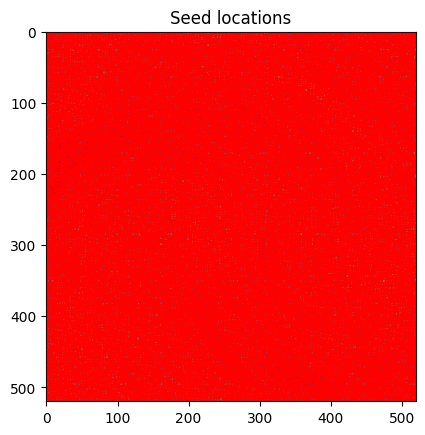

In [378]:
n_points = int(hyp('n_points')) #Nb this is log_10(number of actual points)
generator = qmc.Sobol(2,bits=n_points, seed = random_seed)
seeds = np.uint64(generator.random_base2(m=n_points)*520)
plt.imshow(im_maxvar)
plt.plot(seeds[:,0], seeds[:,1], 'r+')
plt.title('Seed locations')


2. For each seed, flood fill up to a threshold level T.
3. If the area is too large, reduct T.
4. Perform region closure on the brushstroke

In [379]:
min_ratio = hyp('min_ratio')
max_ratio = hyp('max_ratio')
max_brush_width_low = hyp('max_brush_width_low')
max_brush_width_high = hyp('max_brush_width_low')

def it_is_a_brushstroke(brushstroke):

    # brushstroke_edited = np.int8(brushstroke)*255
    retVal = True
    
    brushstroke_reshaped = np.reshape(brushstroke, np.size(brushstroke))
    brushstroke_reshaped = np.bool8(brushstroke_reshaped)
    x_ords_selected = x_ordinates[brushstroke_reshaped]
    y_ords_selected = y_ordinates[brushstroke_reshaped]
    x_ords_zero_mean = x_ords_selected - np.mean(x_ords_selected)
    y_ords_zero_mean = y_ords_selected - np.mean(y_ords_selected)
    x_ords_zero_mean = np.array([x_ords_zero_mean])
    y_ords_zero_mean = np.array([y_ords_zero_mean])
    coords_selected = np.vstack((x_ords_zero_mean, y_ords_zero_mean))
    covariance_matrix = coords_selected @ coords_selected.T / np.shape(coords_selected)[1]
    (evals, evecs) = np.linalg.eig(covariance_matrix)
    evals = np.abs(evals)
    argument = np.argmax(evals)
    sf = 20
    # brushstroke_edited_d = cv2.dilate(brushstroke_edited, np.array([[1,1,1],[1,1,1],[1,1,1]]))
    # brushstroke_edited = np.bool8(brushstroke_edited_d - brushstroke_edited)
    # im_edited = im.copy()
    # im_edited[brushstroke_edited,1] = 0
    # im_edited[brushstroke_edited,0] = 0
    # im_edited[brushstroke_edited,2] = 255
    if evals[argument]/evals[1-argument] < min_ratio*min_ratio:
        retVal = False
    #     im_edited = cv2.putText(im_edited, "Low Ratio: "+str(evals[argument]/evals[1-argument]), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 
    #                1, (0,0,255), 1, cv2.LINE_AA)
    # else:
        # im_edited = cv2.putText(im_edited, "Ratio Ok: "+str(evals[argument]/evals[1-argument]), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 
                #    1, (0,255,0), 1, cv2.LINE_AA)
    # if evals[argument]/evals[1-argument] > max_ratio:
    #     retVal = False
    if evals[argument]/evals[1-argument] < 20:
        if evals[1-argument] > max_brush_width_low:
            retVal = False
        #     im_edited = cv2.putText(im_edited, "Too Wide: "+str(evals[1-argument]), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 
        #             1, (0,0,255), 1, cv2.LINE_AA)
        # else:
        #     im_edited = cv2.putText(im_edited, "Width Ok: "+str(evals[1-argument]), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 
        #            1, (0,255,0), 1, cv2.LINE_AA)
    else:
        if evals[1-argument] > max_brush_width_high:
            retVal = False
            # im_edited = cv2.putText(im_edited, "Too Wide: "+str(evals[1-argument]), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 
                    # 1, (0,0,255), 1, cv2.LINE_AA)
    #     else:
    #         im_edited = cv2.putText(im_edited, "Width Ok: "+str(evals[1-argument]), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 
    #                1, (0,255,0), 1, cv2.LINE_AA)
    # if True:
    #     cv2.imwrite("../out/rejected_brushstrokes/"+str(random.randint(0,100))+".jpg", im_edited)
    return retVal

/var/folders/sl/2cy0bqxd30d3glh5qyybpd6w0000gn/T/ipykernel_13452/2339827221.py:31: RuntimeWarning: invalid value encountered in double_scalars
  if evals[argument]/evals[1-argument] < min_ratio*min_ratio:
/var/folders/sl/2cy0bqxd30d3glh5qyybpd6w0000gn/T/ipykernel_13452/2339827221.py:40: RuntimeWarning: invalid value encountered in double_scalars
  if evals[argument]/evals[1-argument] < 20:
/var/folders/sl/2cy0bqxd30d3glh5qyybpd6w0000gn/T/ipykernel_13452/2339827221.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  if evals[argument]/evals[1-argument] < min_ratio*min_ratio:
/var/folders/sl/2cy0bqxd30d3glh5qyybpd6w0000gn/T/ipykernel_13452/2339827221.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  if evals[argument]/evals[1-argument] < 20:


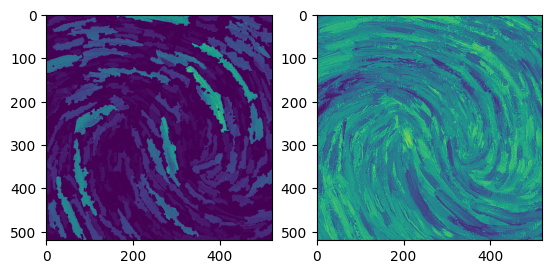

In [380]:
T = int(hyp('init_intensity_bound'))
max_brush = hyp('max_brush_size')
min_brush = hyp('min_brush_size')

im_out = np.zeros(im_maxvar.shape)
brush_options_list = []
region_size_list = []
for seed_index in range(seeds.shape[0]):
    t = T
    region = cv2.floodFill(im, None, seeds[seed_index], 0, (t,t,t), (t,t,t), cv2.FLOODFILL_MASK_ONLY)[2]
    region = region[1:-1,1:-1]
    while (np.sum(region) > max_brush or not it_is_a_brushstroke(region))  and t > 0:
        #3
        t -= 2
        #2
        region = cv2.floodFill(im, None, seeds[seed_index], 0, (t,t,t), (t,t,t), cv2.FLOODFILL_MASK_ONLY)[2]
        region = region[1:-1,1:-1]

    
    #4
    region = cv2.morphologyEx(region, cv2.MORPH_CLOSE, np.ones([4,4]))
    im_out = im_out + im_maxvar * region
    brush_size = np.sum(region)
    if (brush_size > min_brush and it_is_a_brushstroke(region)):
        brush_options_list.append(region)
        region_size_list.append(brush_size)
plt.subplot(1,2,1)
plt.imshow(im_out)
plt.subplot(1,2,2)
plt.imshow(im_maxvar)

4.5 Select for larger brush strokes

5. Reject brush stroke if it is strange


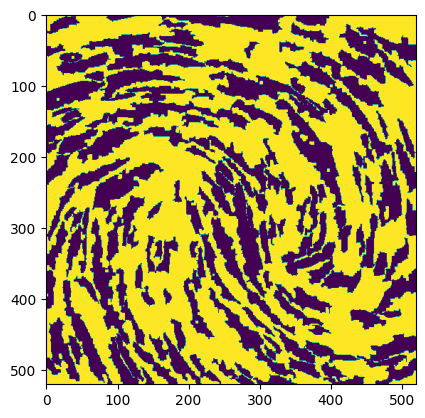

In [381]:
existing_image = np.ones(im_maxvar.shape)


brushstrokes = []
brushtroke_size_list = np.argsort(region_size_list)
# brushtroke_size_list = np.arange(np.size(brushtroke_size_list))
brushtroke_size_list = np.flip(brushtroke_size_list)
sz = np.size(brushtroke_size_list)

#4.5
for i in range(sz):
    region_index = brushtroke_size_list[i]
    add = True
    if np.sum(existing_image*brush_options_list[region_index]) != region_size_list[region_index]:
        add = False
        #5 - Remove small brush strokes
    
    if (region_size_list[region_index] < hyp('min_brush_size')):
        add = False
    #5 - Remove brush strokes which are too wide
    
    if add:
        brushstrokes.append(brush_options_list[region_index])
        existing_image = existing_image*(1-brush_options_list[region_index])
plt.imshow(existing_image)
plt.imsave("../res/starry_night_brushes.jpg", existing_image)

Now we want to extract a vector field. Do this by fitting an x-y line to each brushstroke, assigning vectors in that brushstroke to the direction of that x-y line.

Note that to find direction we use:

$X^Tw=y^T$

$XX^Tw=Xy^T$

Solve for $w$

In [382]:
directions = []




for r in range(len(brushstrokes)):
    selection = np.bool8(np.reshape(brushstrokes[r], np.size(im_maxvar)))
    selected_x = np.array([x_ordinates[selection]])
    selected_x -= np.mean(selected_x)
    selected_y = np.array([y_ordinates[selection]])
    selected_y -= np.mean(selected_y)
    selected_x = np.vstack((selected_x, np.ones([1,np.size(selected_x)])))
    m = np.linalg.solve(selected_x@selected_x.T,selected_x@selected_y.T)[0,0] #Nb [1,0] would refer to the constant term. w ∈ R^{2,1}
    directions.append((m))
#print(directions)

Let's make a quiver plot

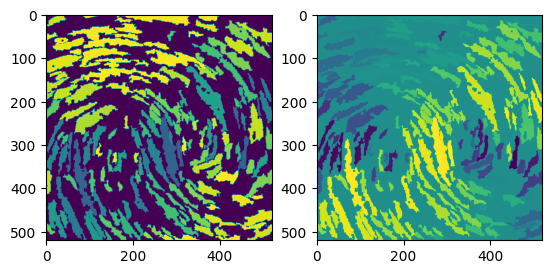

In [383]:
U = np.zeros(im_maxvar.shape)
V = np.zeros(im_maxvar.shape)
for i in range(len(directions)):
    U = U+brushstrokes[i]*1/(np.sqrt(directions[i]*directions[i]+1))
    V = V+brushstrokes[i]*directions[i]/(np.sqrt(directions[i]*directions[i]+1))
plt.subplot(1,2,1)
plt.imshow(U)
plt.subplot(1,2,2)
plt.imshow(V)


In [384]:
with open('../out/m.pkl', 'wb') as outp:
    pickle.dump(directions, outp, pickle.HIGHEST_PROTOCOL)
with open('../out/strokes.pkl', 'wb') as outp:
    pickle.dump(brushstrokes, outp, pickle.HIGHEST_PROTOCOL)

In [8]:
from manim import *
from manim import hex_to_rgb
import pickle
import numpy as np



with open('../out/U.pkl', 'rb') as inp:
    U = np.real(pickle.load(inp))
with open('../out/V.pkl', 'rb') as inp:
    V = np.real(pickle.load(inp))

sz = np.shape(U)

n_points_y = sz[0]
n_points_x = sz[1]

aspect_ratio = n_points_x/n_points_y
coordinates_x = np.ones([n_points_y,1]) @ np.array([np.arange(start = 0, stop = aspect_ratio,step = aspect_ratio/n_points_x)])#linspace(0,aspect_ratio, n_points_x);
coordinates_y = np.array([np.arange(0,1,1/n_points_y)]).T * np.ones([1,n_points_x])

wavenumbers_1d_x = np.fft.fftfreq(n_points_x)
wavenumbers_1d_y = np.fft.fftfreq(n_points_y)
#wavenumbers_1d_x = [0:((n_points_x - rem(n_points_x,2))/2-1), -((n_points_x - rem(n_points_x,2))/2):-1];
n_fft_points_x = np.shape(wavenumbers_1d_x)[0]
#wavenumbers_1d_y = [0:((n_points_y - rem(n_points_y,2))/2-1), -((n_points_y - rem(n_points_y,2))/2):-1];
n_fft_points_y = np.shape(wavenumbers_1d_y)[0]

wavenumbers_x = np.ones([n_fft_points_y,1]) @ np.array([wavenumbers_1d_x])
wavenumbers_y = np.array([wavenumbers_1d_x]).T @ np.ones([1,n_fft_points_x])



def curl_fft_UV(U,V):
    d_u_d_y_fft = 1j * wavenumbers_y * np.fft.fft2(U)
    d_v_d_x_fft = 1j * wavenumbers_x * np.fft.fft2(V)
    curl_fft = d_v_d_x_fft - d_u_d_y_fft
    return curl_fft
def curl(curl_fft):
    # print(curl_fft.shape)
    curl = np.fft.ifft2(curl_fft, np.shape(U))
    curl = np.real(curl)
    return curl
F = np.copy(curl(curl_fft_UV(U,V)))
print(F.shape)
mn = np.min(F)
print(np.min(F))
print(mn)
F -= mn
mx = np.max(F)
F /= mx
print(np.max(F))

(520, 520)
-0.0022012460206039457
-0.0022012460206039457
1.0
